# <p style='text-align: center;'><font color='#474747'>PROJECT. Определяем количество ботов на сайте</font></p>
## <font color='#00b43f'>Задачи:</font> 
1. *Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.*
2. *Определить, с каких источников и в какое время суток чаще всего заходят роботы.* 
**Примечание.** Роботами могут быть пауки поисковых систем, которые индексируют контент блога, или же различные парсеры и агрегаторы контента. «Яндекс.Метрика» позволяет находить этих роботов и показывает их в отдельном параметрe *ym:s:isRobot*, а также считает их долю в специальной метрике *ym:s:robotPercentage*.

### Приступим к вопросу № 1
**Определяем параметры запроса**  
Все параметры мы передаём в составе одного словаря. Назовем этот словарь params. Ключ словаря — это наименование параметра запроса (например, metrics), а значение по ключу — значение этого параметра (например, ym:s:visits).

In [2]:
import json # Устанавливаем необходимые библиотеки
import requests 
import pandas as pd 
from pprint import pprint 
# Выполняем запрос к ЯНДЕКС.Метрике
token = 'AQAAAAALDQk1AAcgGewpFxxtRUrRjjfYkKZ6Wys' # вставляем свой токен
headers = {'Authorization': 'OAuth ' + token} # создадим словарь headers, который будет содержать параметры заголовков HTTP
# используем параметры запроса: ym:s:visits — количество визитов, ym:s:robotPercentage - доля роботов
params = {'metrics': 'ym:s:visits,ym:s:robotPercentage', 
          'dimensions': 'ym:s:lastsignTrafficSource,ym:s:hour',  
          'date1': '2020-09-01',  
          'date2': '2020-09-30',     
          'ids': 30177909,
          'accuracy':'full',
          'limit':100000} 
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers) # выполняем GET-запрос к адресу
print(response.status_code) # Проверяем статус (если 200 - успешно, 404 - ошибка и т.д.)
metrika_data = response.json() # Записываем в json-файл

200


#### <font color='#548eaa'>Комментарий к коду выше.</font>
**Параметры запроса**  
Итак, мы используем следующие варианты параметров запроса:  

- **metrics** — метрики, то есть количественные показатели, характеризующие посетителей сайта;  
- **dimensions** — группировки, определяющие, по каким критериям все посетители сайта будут объединены в группы;  
- **date1** — начало периода, данные по которому будут помещены в отчет;  
- **date2** — окончание периода, данные по которому будут помещены в отчет; 
- **limit** — максимально допустимое количество строк в отчёте;
- **offset** — номер строки отчёта, с которой должна начаться выгрузка данных;
- **ids** — номер счётчика, установленный на сайте.

In [3]:
print(metrika_data.keys()) # Посмотрим какие ключи находятся в полученном файле

dict_keys(['query', 'data', 'total_rows', 'total_rows_rounded', 'sampled', 'contains_sensitive_data', 'sample_share', 'sample_size', 'sample_space', 'data_lag', 'totals', 'min', 'max'])


### Избавляемся от вложенных словарей  
Напишем несложную функцию **getMetrikaDataInListOfDicts():** 

In [4]:
def getMetrikaDataInListOfDicts(metrika_data): #преобразуем данные в так называемый плоский вид
    list_of_dicts = [] # Создаём пустой список
    dimensions_list = metrika_data['query']['dimensions'] # возьмём список по ключам 'query' и 'dimensions'
    metrics_list = metrika_data['query']['metrics'] # возьмём список по ключам 'query' и 'metrics'
    for data_item in metrika_data['data']: # Пройдёмся циклом по списку с ключом 'data'
        d = {} # Создадим пустой словарь
        for i,dimension in enumerate(data_item['dimensions']): 
            d[dimensions_list[i]] = dimension['name'] # запишем в словарь по ключу из списка выше - значение из списка 'dimensions'
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric # запишем в словарь по ключу из списка выше - значение из списка 'metrics'
        list_of_dicts.append(d) # добавим в список полученный словарь
    return list_of_dicts

Преобразуем наши данные с помощью этой функции и запишем в переменную metrika_list_of_dicts:

In [5]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
pprint(metrika_list_of_dicts[0:5]) #Преобразуем наши данные с помощью этой функции и запишем в переменную metrika_list_of_dicts

[{'ym:s:hour': '16:00',
  'ym:s:lastsignTrafficSource': 'Search engine traffic',
  'ym:s:robotPercentage': 24.70119522,
  'ym:s:visits': 251.0},
 {'ym:s:hour': '15:00',
  'ym:s:lastsignTrafficSource': 'Search engine traffic',
  'ym:s:robotPercentage': 26.25,
  'ym:s:visits': 240.0},
 {'ym:s:hour': '11:00',
  'ym:s:lastsignTrafficSource': 'Search engine traffic',
  'ym:s:robotPercentage': 25.87719298,
  'ym:s:visits': 228.0},
 {'ym:s:hour': '13:00',
  'ym:s:lastsignTrafficSource': 'Search engine traffic',
  'ym:s:robotPercentage': 28.1938326,
  'ym:s:visits': 227.0},
 {'ym:s:hour': '12:00',
  'ym:s:lastsignTrafficSource': 'Search engine traffic',
  'ym:s:robotPercentage': 24.88888889,
  'ym:s:visits': 225.0}]


**Создаём датафрейм**

In [6]:
metrika_df = pd.DataFrame(metrika_list_of_dicts) #создадим датафрейм metrika_df
display(metrika_df.head(10)) # Выведем на экран датафрейм

,ym:s:lastsignTrafficSource,ym:s:hour,ym:s:visits,ym:s:robotPercentage
0,Search engine traffic,16:00,251.0,24.701195
1,Search engine traffic,15:00,240.0,26.250000
2,Search engine traffic,11:00,228.0,25.877193
3,Search engine traffic,13:00,227.0,28.193833
4,Search engine traffic,12:00,225.0,24.888889
5,Search engine traffic,14:00,225.0,25.777778
6,Search engine traffic,17:00,209.0,26.315789
7,Search engine traffic,10:00,186.0,19.354839
8,Search engine traffic,21:00,166.0,17.469880
9,Search engine traffic,19:00,161.0,23.602484


In [7]:
metrika_df.columns=['Source','Hour', 'Visits','Percentage'] # Для удобства переименуем столбцы
metrika_df['Bots_visits']=metrika_df['Visits']*metrika_df['Percentage']/100 # добавим новый столбец с расчётом количества ботов

In [8]:
metrika_df=metrika_df.astype({'Visits': 'Int64'}) # преобразуем тип данных в столбце 'Visits' в целое число
metrika_df['Bots_visits']=round(metrika_df['Bots_visits'],0) # округлим количество ботов до целого числа
metrika_df=metrika_df.astype({'Bots_visits': 'Int64'}) # преобразуем тип данных в столбце 'Bots_visits' в целое число
metrika_df # Выведем на экран

,Source,Hour,Visits,Percentage,Bots_visits
0,Search engine traffic,16:00,251,24.701195,62
1,Search engine traffic,15:00,240,26.250000,63
2,Search engine traffic,11:00,228,25.877193,59
3,Search engine traffic,13:00,227,28.193833,64
4,Search engine traffic,12:00,225,24.888889,56
...,...,...,...,...,...
102,Social network traffic,02:00,1,0.000000,0
103,Social network traffic,04:00,1,0.000000,0
104,Social network traffic,10:00,1,0.000000,0
105,Recommendation system traffic,08:00,1,0.000000,0


In [9]:
metrika_df.info() # Проверим наличие пропусков в таблице (всего 107 строк, в каждом столбце тоже по 107 строк - пропусков нет!)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Source       107 non-null    object 
 1   Hour         107 non-null    object 
 2   Visits       107 non-null    Int64  
 3   Percentage   107 non-null    float64
 4   Bots_visits  107 non-null    Int64  
dtypes: Int64(2), float64(1), object(2)
memory usage: 4.5+ KB


In [10]:
# Создадим сводные таблицы со значениями визитов - в одной таблице, и визитов ботов - в другой 
# при этом колонками будут источники по которым суммируем количество визитов
counts_bots1=metrika_df.pivot_table(values=['Visits'], columns=['Source'], aggfunc={'Visits':'sum'}) 
counts_bots1=counts_bots1.fillna(0) # заменим пустые значения на 0
display(counts_bots1) 
counts_bots2=metrika_df.pivot_table(values=['Bots_visits'], columns=['Source'], aggfunc={'Bots_visits':'sum'})
counts_bots2=counts_bots2.fillna(0) # заменим пустые значения на 0
display(counts_bots2) 
# Выведем на экран сразу обе таблицы, чтобы можно было сравнивать

,Cached page traffic,Direct traffic,Internal traffic,Link traffic,Recommendation system traffic,Search engine traffic,Social network traffic
Visits,6,757,10,126,2,3334,80


,Cached page traffic,Direct traffic,Internal traffic,Link traffic,Recommendation system traffic,Search engine traffic,Social network traffic
Bots_visits,1,177,3,31,0,739,11


Из двух сводных таблиц создадим одну сводную таблицу со столбцом доли количества ботов от каждого трафика в % и суммарную строку по всему трафику:

In [11]:
counts_bots=counts_bots1 
counts_bots=counts_bots.append(counts_bots2, ignore_index=False) 
counts_bots['Total']=counts_bots['Cached page traffic']+counts_bots['Direct traffic']+counts_bots['Internal traffic']+counts_bots['Link traffic']+counts_bots['Recommendation system traffic']+counts_bots['Search engine traffic']+counts_bots['Social network traffic'] 
counts_botss=counts_bots.T # для удобства использования транспонируем таблицу
counts_botss['Ratio_bots']=counts_botss['Bots_visits']*100/counts_botss['Visits'] # Добавим колонку, в которой будет содержатся доля ботов
display(counts_botss.sort_values(by=['Bots_visits'])) # Выведем на экран, отсортировав по количеству визитов ботов по возрастанию

,Visits,Bots_visits,Ratio_bots
Recommendation system traffic,2,0,0.000000
Cached page traffic,6,1,16.666667
Internal traffic,10,3,30.000000
Social network traffic,80,11,13.750000
Link traffic,126,31,24.603175
Direct traffic,757,177,23.381770
Search engine traffic,3334,739,22.165567
Total,4315,962,22.294322


## <font color='#0000CC'>Вывод по первому вопросу:</font> 
Из таблицы видно, что доля количества ботов от всего трафика составляет **22,29%**.

### Приступим к вопросу № 2 
Для получения ответа на второй вопрос создадим сводную таблицу, где строками будет время, а столбцами - источники

In [12]:
counts_bots_hour=metrika_df.pivot_table(values=['Bots_visits'], # Создадим сводную таблицу
                                                        index=['Hour'],
                                                        columns=['Source'],
                                                        aggfunc='sum',
                                                        margins=True,
                                       margins_name='Total')
counts_bots_hour=counts_bots_hour.fillna(0) # Заменим пропуски на 0
display(counts_bots_hour) # Выведем на экран сводную таблицу

Bots_visits                                               \
Source Cached page traffic Direct traffic Internal traffic Link traffic   
Hour                                                                      
00:00                    0              2                0            0   
01:00                    1              4                0            0   
02:00                    0              2                0            0   
03:00                    0              2                0            1   
04:00                    0              3                0            0   
05:00                    0              3                0            0   
06:00                    0              3                0            2   
07:00                    0              5                0            1   
08:00                    0              5                0            1   
09:00                    0             12                1            1   
10:00                    0              9                0            6   
11:00                    0              8                0            3   
12:00                    0             15                1            2   
13:00                    0             13                0            1   
14:00                    0             14                0            2   
15:00                    0              6                0            1   
16:00                    0              8                1            3   
17:00                    0              9                0            2   
18:00                    0              9                0            1   
19:00                    0             10                0            0   
20:00                    0              8                0            2   
21:00                    0             13                0            0   
22:00                    0              6                0            1   
23:00                    0              8                0            1   
Total                    1            177                3           31   

                                                            \
Source Recommendation system traffic Search engine traffic   
Hour                                                         
00:00                              0                    17   
01:00                              0                     8   
02:00                              0                     5   
03:00                              0                     3   
04:00                              0                     3   
05:00                              0                     1   
06:00                              0                     3   
07:00                              0                     6   
08:00                              0                    29   
09:00                              0                    36   
10:00                              0                    36   
11:00                              0                    59   
12:00                              0                    56   
13:00                              0                    64   
14:00                              0                    58   
15:00                              0                    63   
16:00                              0                    62   
17:00                              0                    55   
18:00                              0                    31   
19:00                              0                    38   
20:00                              0                    26   
21:00                              0                    29   
22:00                              0                    30   
23:00                              0                    21   
Total                              0                   739   

                                     
Source Social network traffic Total  
Hour                                 
00:00                       0    19  
01:00                    

In [14]:
# Получилась довольно большая таблица для восприятия, чтобы лучше оценить её - выведем её показатели
counts_bots_hour.describe() 

Bots_visits                                               \
Source Cached page traffic Direct traffic Internal traffic Link traffic   
count            25.000000      25.000000        25.000000     25.00000   
mean              0.080000      14.160000         0.240000      2.48000   
std               0.276887      34.153672         0.663325      6.09043   
min               0.000000       2.000000         0.000000      0.00000   
25%               0.000000       4.000000         0.000000      0.00000   
50%               0.000000       8.000000         0.000000      1.00000   
75%               0.000000      10.000000         0.000000      2.00000   
max               1.000000     177.000000         3.000000     31.00000   

                                                            \
Source Recommendation system traffic Search engine traffic   
count                           25.0             25.000000   
mean                             0.0             59.120000   
std                              0.0            143.293789   
min                              0.0              1.000000   
25%                              0.0              8.000000   
50%                              0.0             30.000000   
75%                              0.0             56.000000   
max                              0.0            739.000000   

                                           
Source Social network traffic       Total  
count               25.000000   25.000000  
mean                 0.880000   76.960000  
std                  2.242023  186.167371  
min                  0.000000    4.000000  
25%                  0.000000   13.000000  
50%                  0.000000   41.000000  
75%                  1.000000   70.000000  
max                 11.000000  962.000000

Так как максимальное значение намного превосходит остальные значения в строках, будем использовать 75% персентиль по колонке **"Total"**

In [15]:
# Выберем строки со значениями больше 70 (75% персентиль)
counts_bots_hour75=counts_bots_hour[counts_bots_hour['Bots_visits']['Total']>70] 
display(counts_bots_hour75) # Выведем на экран получившуюся таблицу

Bots_visits                                               \
Source Cached page traffic Direct traffic Internal traffic Link traffic   
Hour                                                                      
12:00                    0             15                1            2   
13:00                    0             13                0            1   
14:00                    0             14                0            2   
15:00                    0              6                0            1   
16:00                    0              8                1            3   
Total                    1            177                3           31   

                                                            \
Source Recommendation system traffic Search engine traffic   
Hour                                                         
12:00                              0                    56   
13:00                              0                    64   
14:00                              0                    58   
15:00                              0                    63   
16:00                              0                    62   
Total                              0                   739   

                                     
Source Social network traffic Total  
Hour                                 
12:00                       1    75  
13:00                       2    80  
14:00                       0    74  
15:00                       1    71  
16:00                       1    75  
Total                      11   962

<AxesSubplot:title={'center':'Количество посещений ботов по источникам'}, xlabel='Hour'>

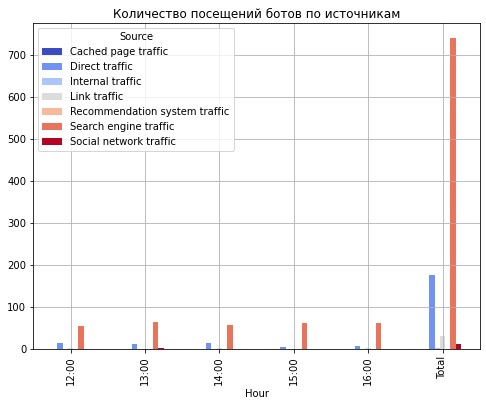

In [47]:
# Построим столбчатую диаграмму по сводной таблице выше
import matplotlib.pyplot as plt 
counts_bots_hour75['Bots_visits'].iloc[:,:7].plot(kind = 'bar', figsize=(8, 6), 
                              grid = True, 
                              colormap = 'coolwarm', 
                              title = 'Количество посещений ботов по источникам', xlabel='Hour')

## <font color='#0000CC'>Вывод по второму вопросу:</font> 
Из столбчатой диаграммы видно, что чаще всего заходят роботы из источника: <font color='#FF5050'>**"Search engine traffic"**</font>, но в вопрос ставился по выделению нескольких источников, поэтому вторым по значимости будет: <font color='#3366FF'>**"Direct traffic"**. </font>Время, когда больше всего заходят боты: с <font color='#990000'>**12**</font> до <font color='#990000'>**16 часов**</font>.